## Linear regression with multiple variables
1. [读取数据](#读取数据)
2. [画出数据直方图](#画出数据直方图)
3. [构建模型](#构建模型)
4. [梯度下降训练模型](#梯度下降训练模型)
5. [Plot the convergence graph](#pcg)
5. [另一种画convergence graph的方式](#cg)
5. [预测一个新的样本](#预测一个新的样本)
5. [正规方程求解](#正规方程求解)

In [1]:
%matplotlib inline
# %pylab
import numpy as np
import matplotlib.animation as animation 
import matplotlib.pyplot as plt
from matplotlib import style 
import theano
import theano.tensor as T

/home/lsr/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)


### 读取数据

In [2]:
data = np.loadtxt('ex1data2.txt', delimiter=',')
m = len(data)
xt = np.ones((m, 3))
xt[:, (1, 2)] = data[:, (0, 1)] # 给x添加一列1'
labelt = np.zeros((m, 1))
labelt[:, 0] = data[:, 2]

In [3]:
# 特征尺度变换
def featureNormalize(x): 
    mu = x.mean(0)
    #sigma = x.std(0) # 估计的是总体标注差,除以的是m, matlab中是除以m - 1,估计样本标准差
    sigma = np.sqrt(((x - mu) ** 2).sum(0) / (len(x) - 1)) # 样本标准差
    x_norm = (x - mu) / sigma
    return x_norm, mu, sigma

### 画出数据直方图

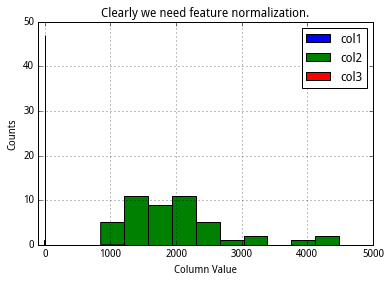

In [5]:
plt.grid(True)
plt.xlim([-100,5000])
dummy = plt.hist(xt[:,0],label = 'col1')
dummy = plt.hist(xt[:,1],label = 'col2')
dummy = plt.hist(xt[:,2],label = 'col3')
plt.title('Clearly we need feature normalization.')
plt.xlabel('Column Value')
plt.ylabel('Counts')
dummy = plt.legend()

In [6]:
# feature normalization
xt = np.ones((m, 3))
xt[:, (1, 2)], mu, sigma = featureNormalize(data[:, (0, 1)]) # 对特征进行尺度变换,然后添加一列 1

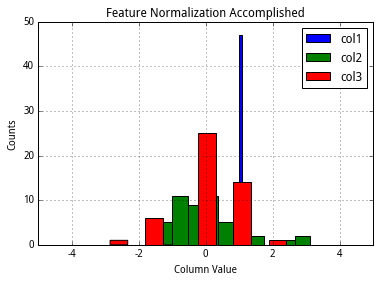

In [7]:
#Quick visualize the feature-normalized data
plt.grid(True)
plt.xlim([-5,5])
dummy = plt.hist(xt[:,0],label = 'col1')
dummy = plt.hist(xt[:,1],label = 'col2')
dummy = plt.hist(xt[:,2],label = 'col3')
plt.title('Feature Normalization Accomplished')
plt.xlabel('Column Value')
plt.ylabel('Counts')
dummy = plt.legend()

### 构建模型

In [8]:
x = T.matrix(name='x', dtype='float64') #  (47 3)
theta_np = np.zeros((3, 1), dtype='float64') 
label = T.matrix(name='label', dtype='float64') # (47 1)
alpha = T.scalar(name='alpha', dtype='float64')
theta = theano.shared(theta_np, name='theta') # (3, 1)

In [9]:
y = x.dot(theta) # (47 1)
predict = theano.function([x], y)
loss = T.mean((y - label) ** 2) / 2 # scalar
calcLoss = theano.function([x, label], loss)
grad_a = T.mean(y - label) # 手动公式求导, scalar
grad_b = T.mean((y - label) * (x[:, 1]).dimshuffle(0, 'x')) #  (y-label)的shape是(47,1),而x[:, 1]的shape是(47,)所有需要使用dimshuffle变成(47,1)
grad_c = T.mean((y - label) * (x[:, 2]).dimshuffle(0, 'x')) 
gradient_step = theano.function([x, label, alpha],updates={theta : theta - alpha * T.stack([[grad_a], [grad_b], [grad_c]])}) # 需要这样stack,或者.dimshuffle(0, 'x')

In [11]:
grad_all =  T.mean((y - label).repeat(3, 1) * x, axis=0)  # 另一种手动求导,一次性求三个变量
gradient_step_all = theano.function([x, label, alpha],updates={theta : theta - alpha * grad_all.dimshuffle(0, 'x')}) 

In [12]:
grad = T.grad(loss, theta) # 自动求导
gradient_step_auto = theano.function([x, label, alpha],updates={theta : theta - alpha * grad}) # 自动求导的gradient_step

In [13]:
calcLoss(xt,labelt)

array(65591548106.45744)

### 梯度下降训练模型

In [14]:
# 直接训练train
theta.set_value(theta_np)
num_iters = 8500
J_history = np.zeros((num_iters, 1))
for i in range(num_iters):
    gradient_step(xt, labelt, 0.01)
    J_history[i] = calcLoss(xt, labelt)
thetaResult = theta.get_value()
print thetaResult

[[ 340412.65957447]
 [ 110631.05027884]
 [  -6649.47427082]]


### Plot the convergence graph<span id='pcg'/>

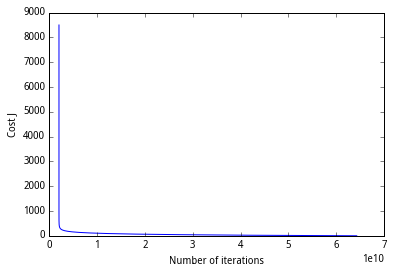

In [15]:
fig = plt.figure() 
plt.plot(J_history, np.arange(num_iters) + 1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

### 另一种画convergence graph的方式<span id='cg'></span>

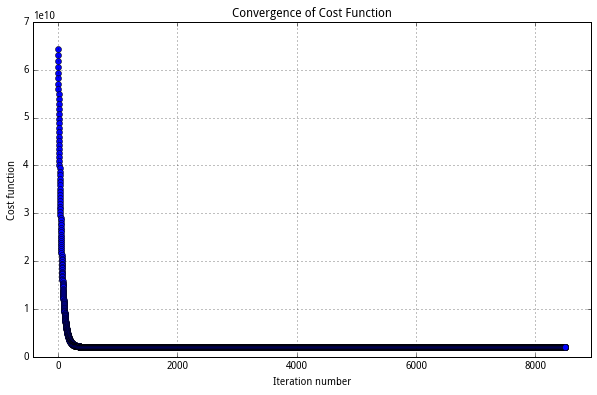

In [16]:
#Plot the convergence of the cost function
def plotConvergence(jvec):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(jvec)),jvec,'bo')
    plt.grid(True)
    plt.title("Convergence of Cost Function")
    plt.xlabel("Iteration number")
    plt.ylabel("Cost function")
    dummy = plt.xlim([-0.05*num_iters,1.05*num_iters])
    #dummy = plt.ylim([4,8])
    
plotConvergence(J_history)

### 预测一个新的样本

In [17]:
def predict(ytest, theta):
    ytest = np.array(ytest)
    ytestscaled = [(ytest[x]-mu[x])/sigma[x] for x in xrange(len(ytest))] # feature normalization,
    ytestscaled.insert(0,1)
    return float(np.array([ytestscaled]).dot(theta))

In [18]:
#print "Final result theta parameters: \n",theta
print "Check of result: What is price of house with 1650 square feet and 3 bedrooms?"
ytest = np.array([1650.,3.])
print "$%0.2f" % predict(ytest, theta.get_value())

Check of result: What is price of house with 1650 square feet and 3 bedrooms?
$293081.46


### 正规方程求解
$\theta = \left( X^T X \right)^{-1} X^T y $

In [19]:
from numpy.linalg import inv
#Implementation of normal equation to find analytic solution to linear regression
def normEqtn(X,y):
    #restheta = np.zeros((X.shape[1],1))
    return np.dot(np.dot(inv(np.dot(X.T,X)),X.T),y)

In [20]:
print "Normal equation prediction for price of house with 1650 square feet and 3 bedrooms"
print "$%0.2f" % predict(ytest, normEqtn(xt,labelt))

Normal equation prediction for price of house with 1650 square feet and 3 bedrooms
$293081.46
